<a href="https://colab.research.google.com/github/jasleenkaursandhu/Reproducing-chest-xray-report-generation-boag/blob/main/nlg_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Successfully imported custom pycocoevalcap3 metrics
Loading reference texts from /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/reference.tsv
Loaded reference texts for 1757 test images

Loading random predictions from /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/random.tsv
Loaded 1757 predictions

Evaluating random model...
Number of cases with both reference and prediction: 1757
{'testlen': 91659, 'reflen': 91118, 'guess': [91659, 89902, 88145, 86388], 'correct': [21308, 4757, 1356, 443]}
ratio: 1.005937355956002
random BLEU scores (n=1757):
  BLEU-1: 0.2325
  BLEU-2: 0.1109
  BLEU-3: 0.0574
  BLEU-4: 0.0314
random CIDEr score (scaled): 0.4704

Loading 1-gram predictions from /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/1-gram.tsv
Loaded 1757 predictions

Evaluating 1-gram model...
Number of cases with both reference and prediction: 1757
{'testlen': 80137, 'reflen': 91118, 'guess': [80137, 78380, 76683, 75022], 'correct': [17974, 436, 3, 

/var/folders/3z/qx32kjf1617b8g5nxnsx443r0000gn/T/ipykernel_34821/2122639330.py:373: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()



Creating visualizations for 2-gram models with different neighbor counts...

Creating visualizations for 3-gram models with different neighbor counts...

Summary of results for n-gram models with different neighbor counts:
 Model Neighbors  BLEU-1  BLEU-2  BLEU-3  BLEU-4  CIDEr
1-gram        10  0.1843  0.0291  0.0042  0.0010 0.1378
1-gram        50  0.1783  0.0279  0.0035  0.0000 0.1206
1-gram       100  0.1833  0.0285  0.0021  0.0000 0.1247
1-gram       200  0.1887  0.0300  0.0027  0.0000 0.1184
2-gram        10  0.1952  0.0955  0.0461  0.0231 0.1732
2-gram        50  0.1981  0.0964  0.0444  0.0200 0.2079
2-gram       100  0.1931  0.0936  0.0428  0.0195 0.2053
2-gram       200  0.1922  0.0933  0.0433  0.0198 0.1970
3-gram        10  0.2052  0.1012  0.0544  0.0306 0.3015
3-gram        50  0.2067  0.1011  0.0544  0.0312 0.2330
3-gram       100  0.1979  0.0968  0.0525  0.0295 0.2874
3-gram       200  0.1994  0.0979  0.0521  0.0286 0.2311

Saved neighbor summary table to /Users/simeon/D

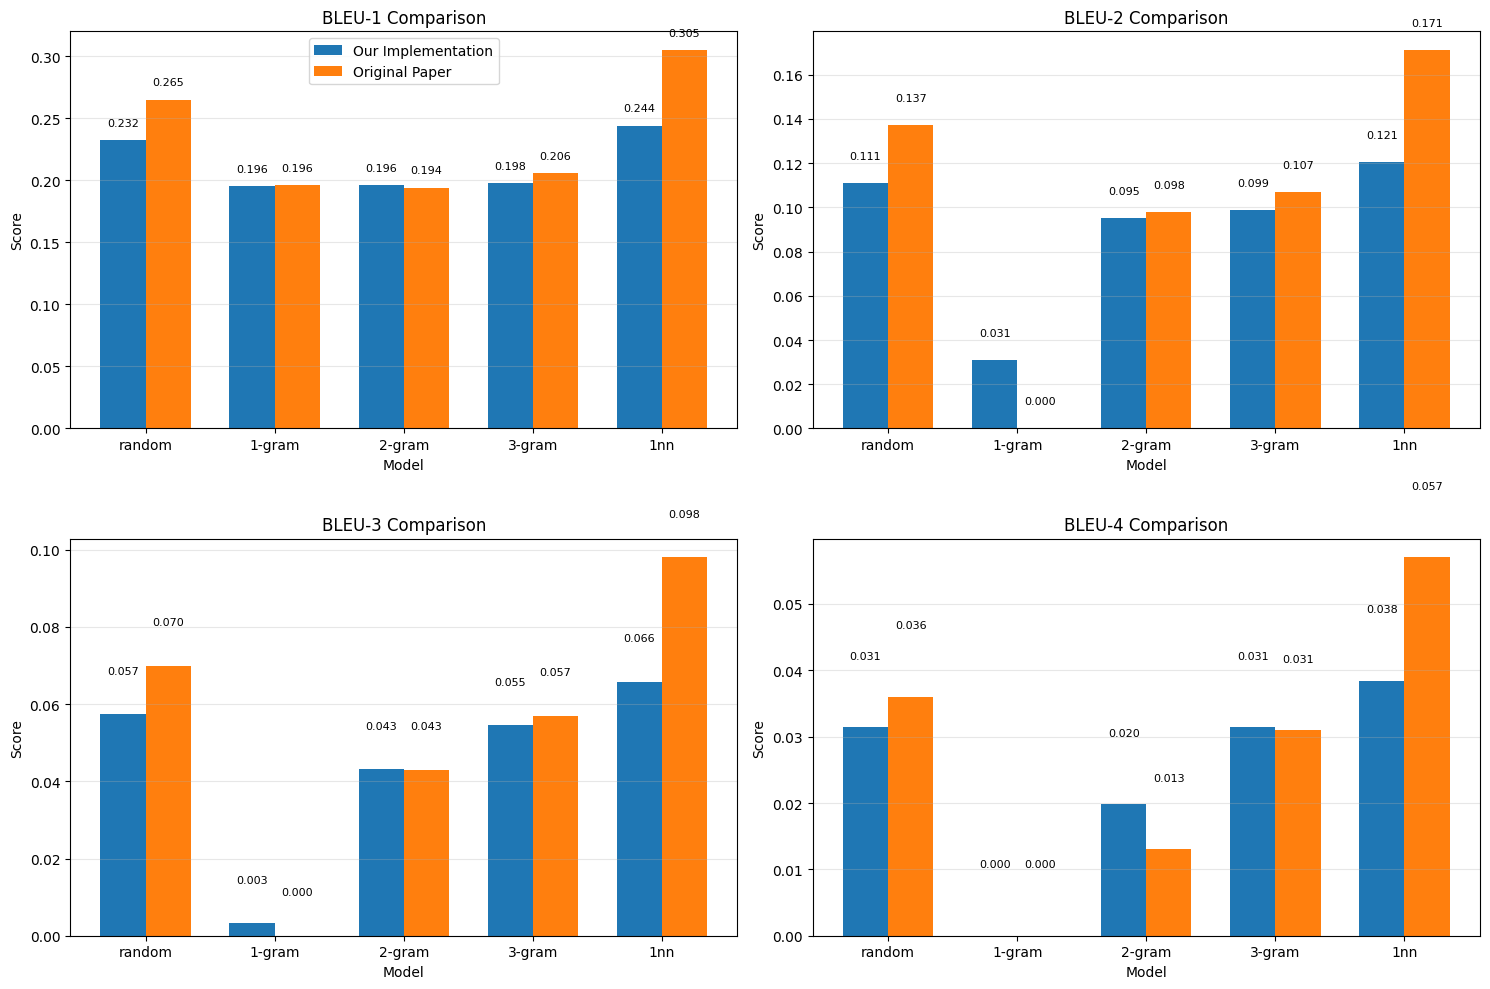

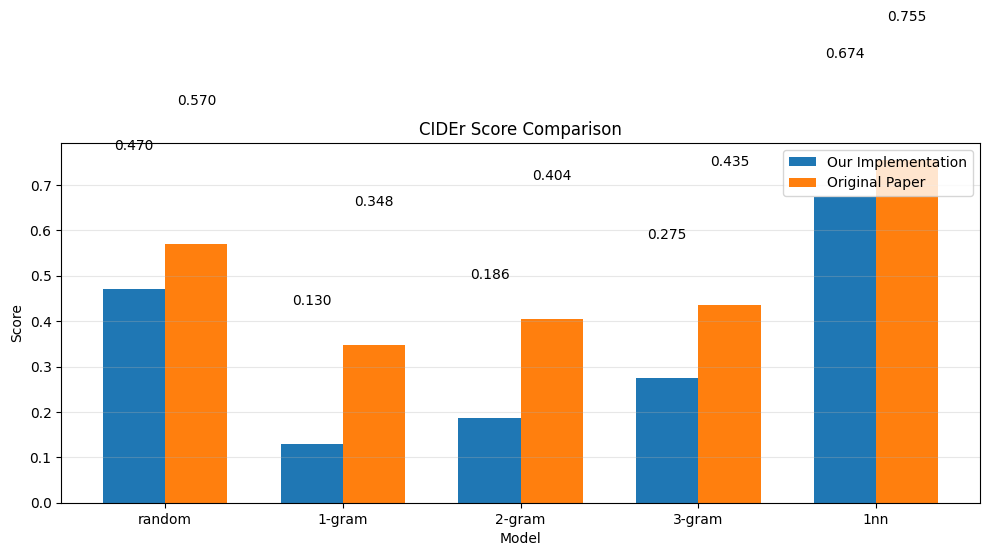

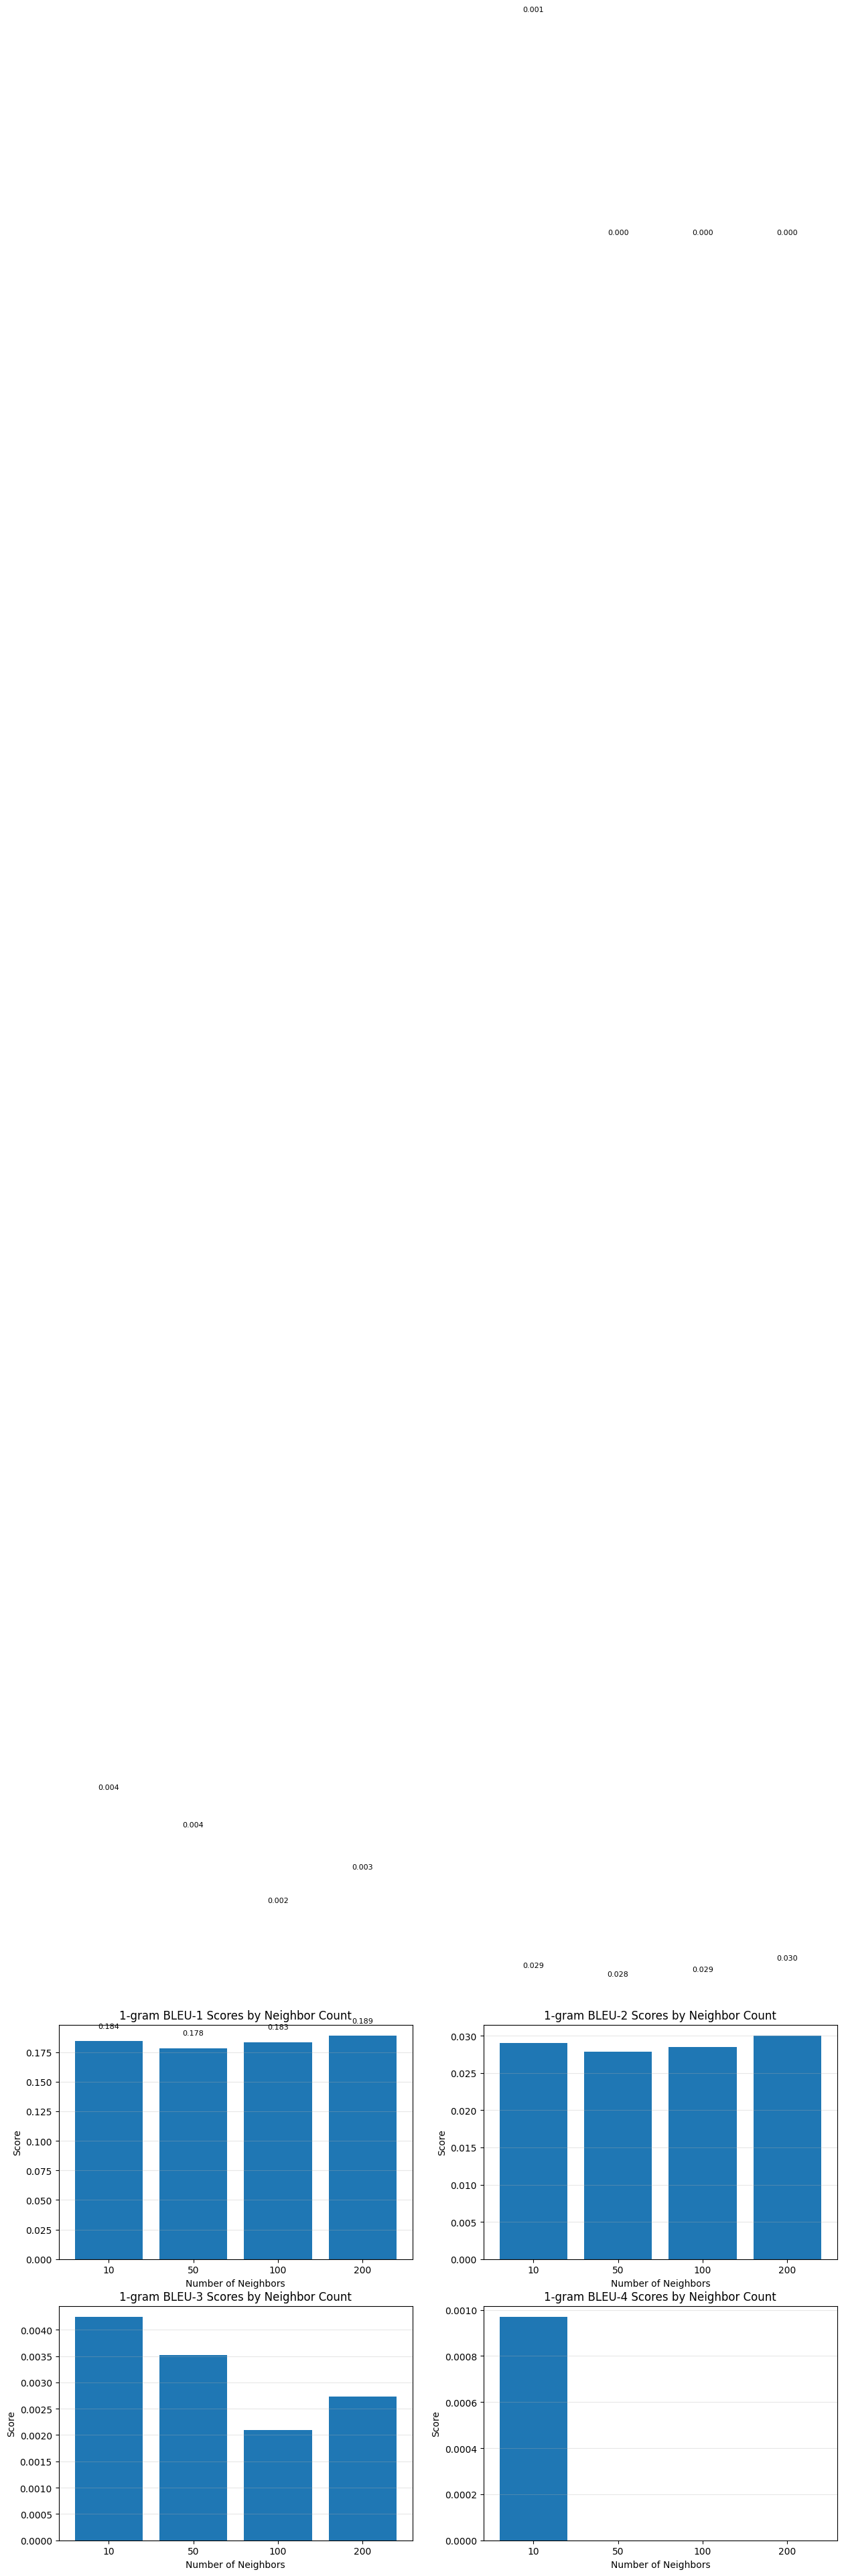

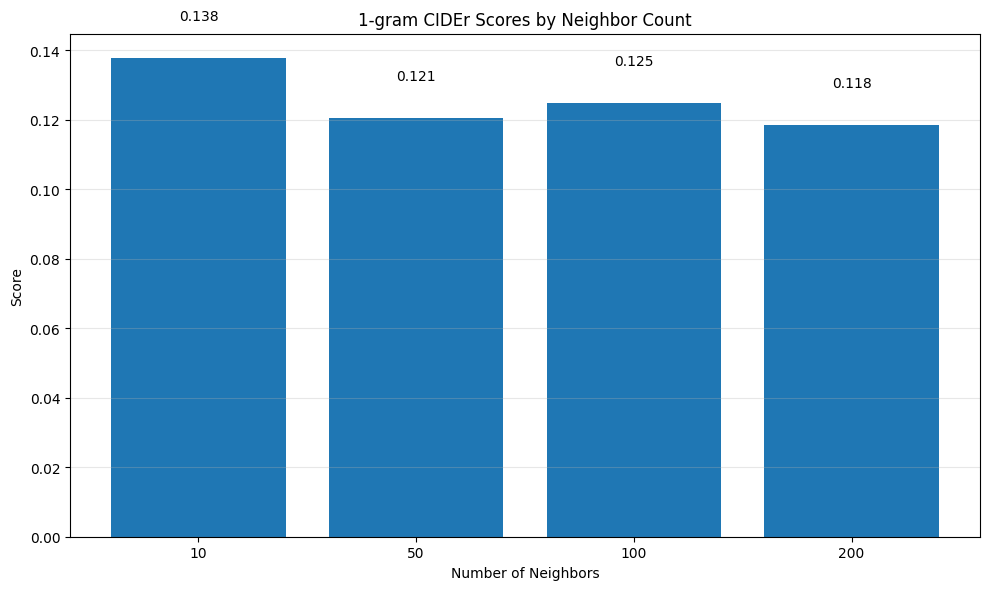

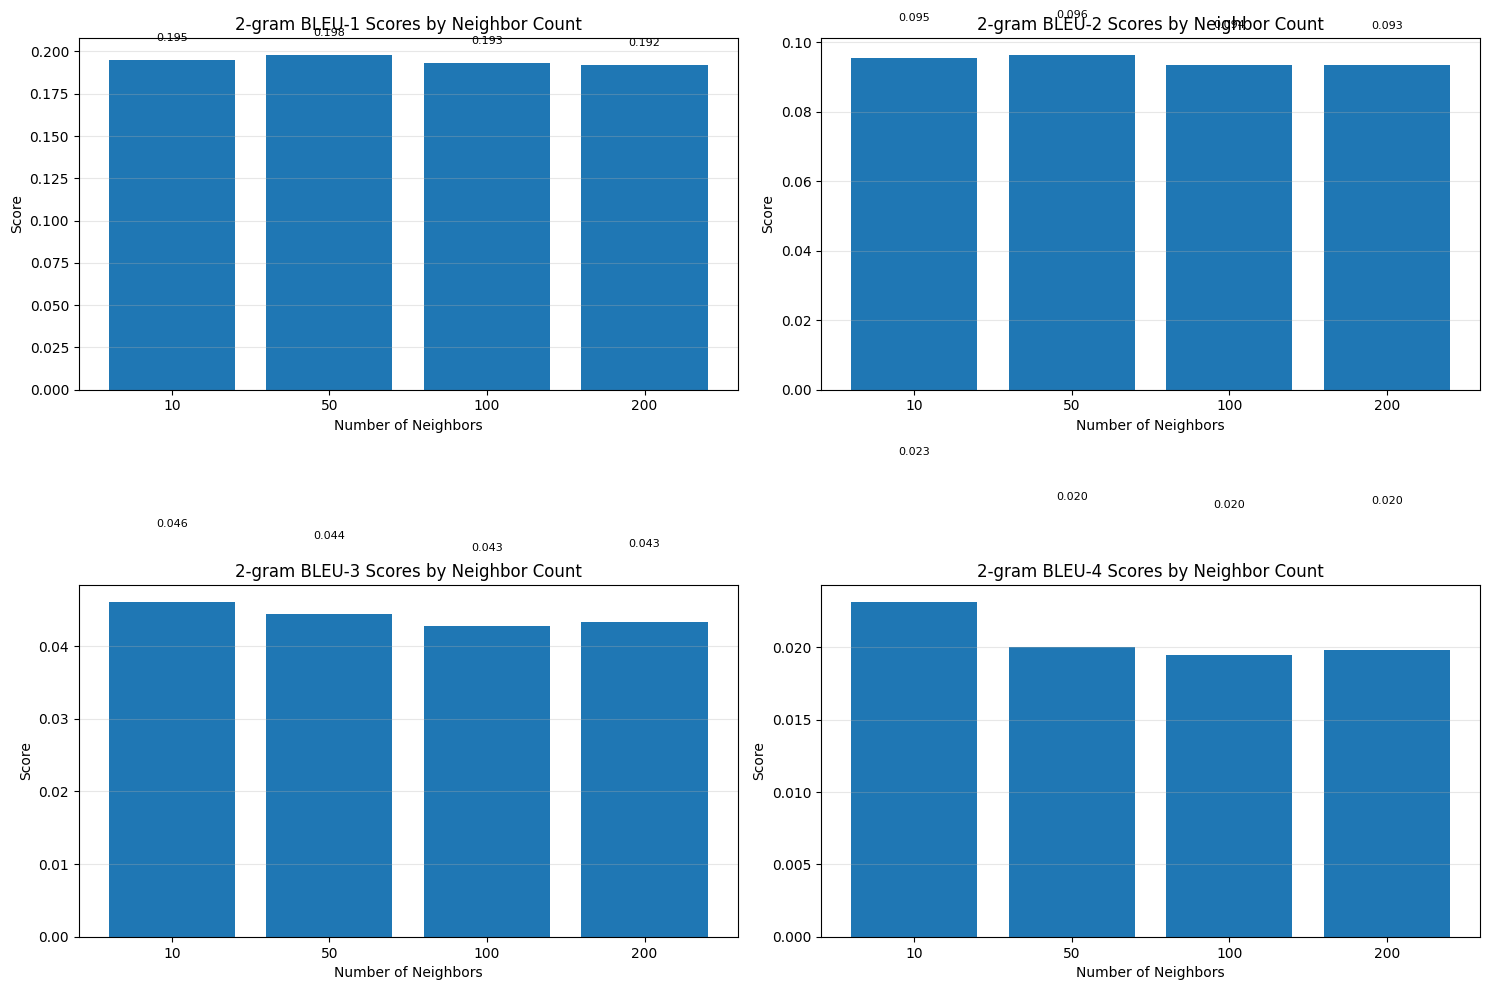

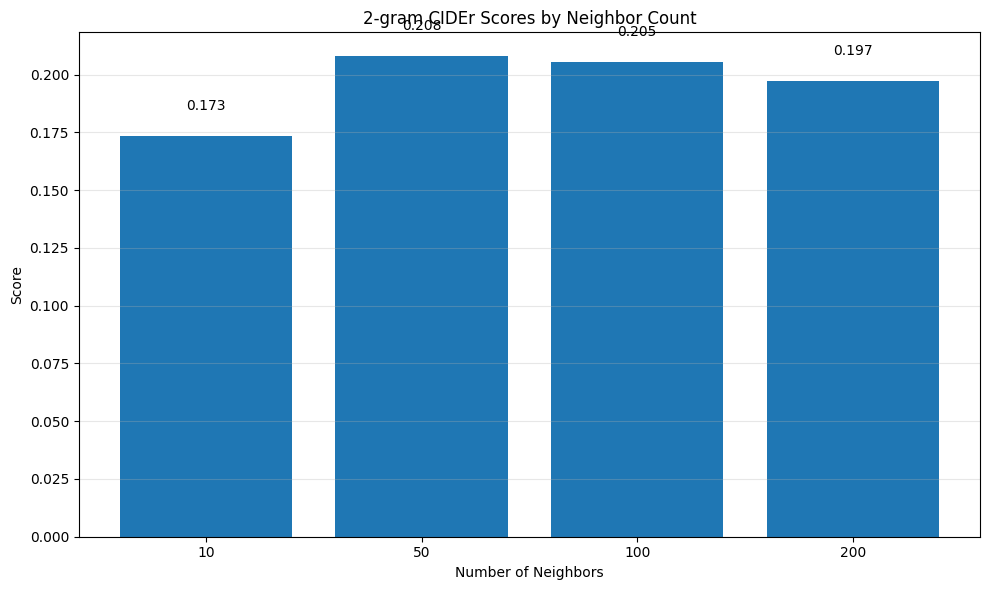

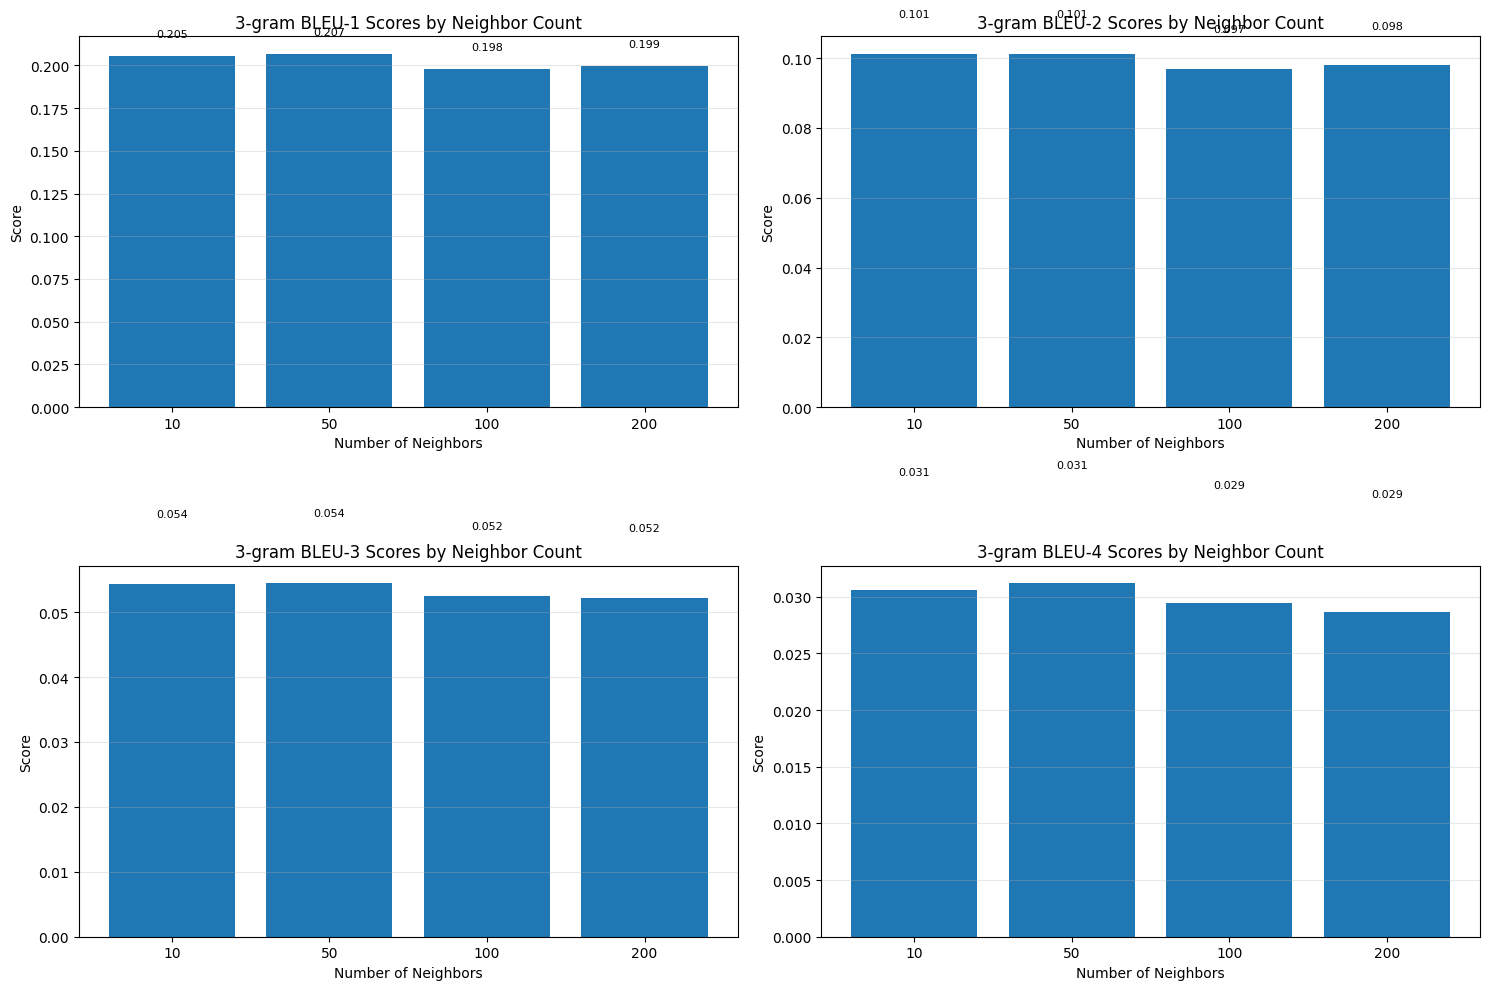

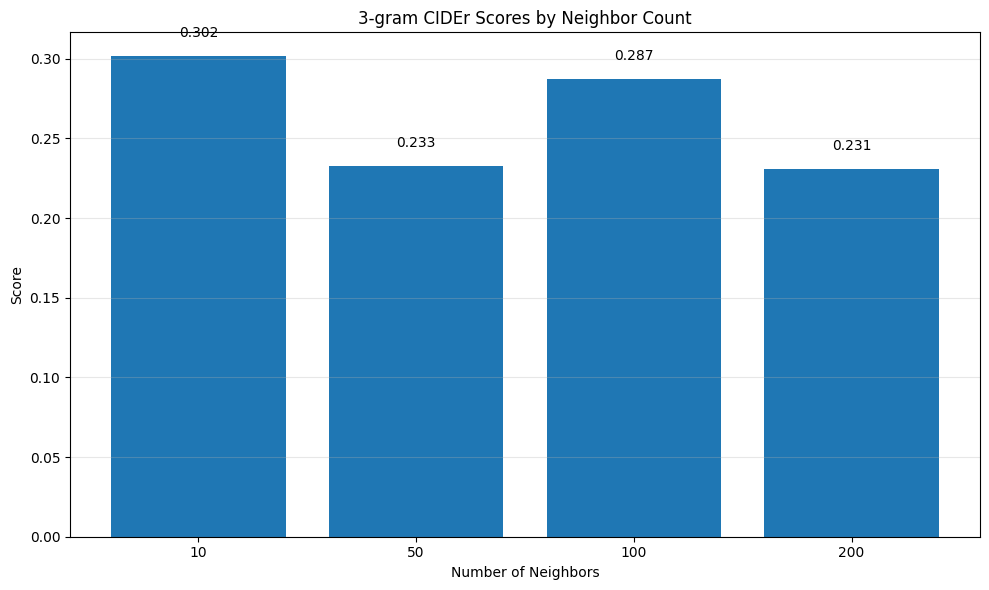

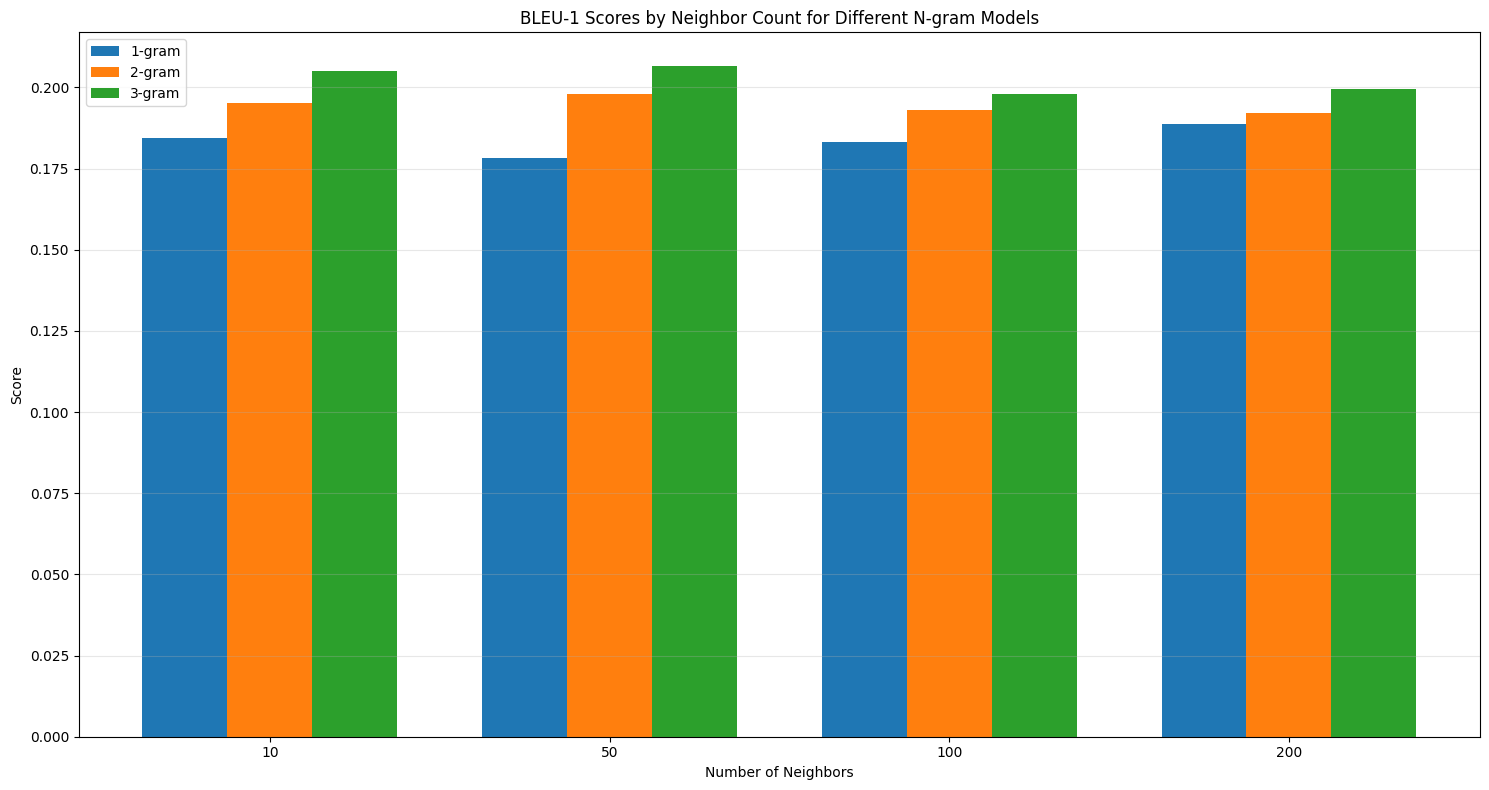

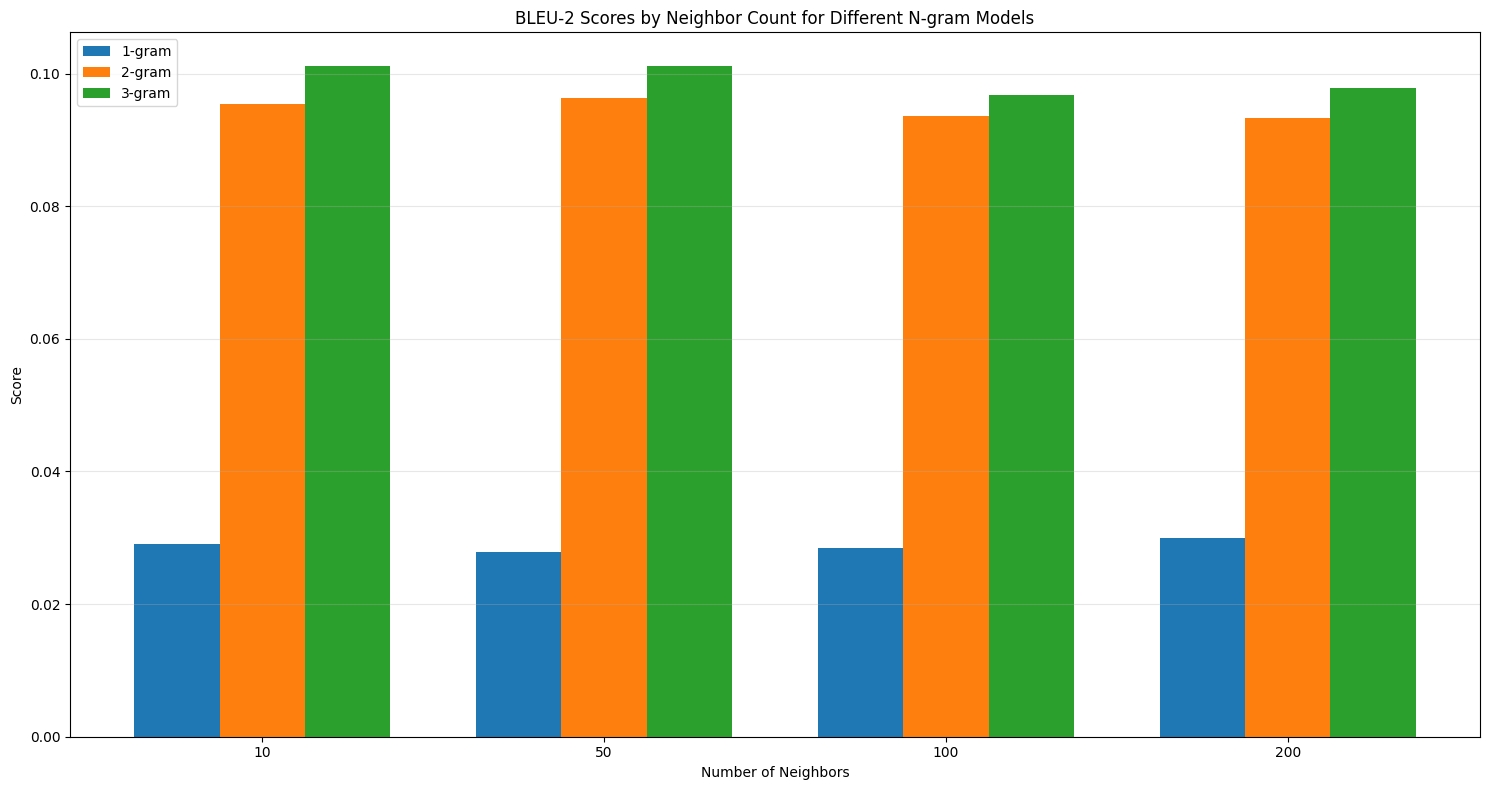

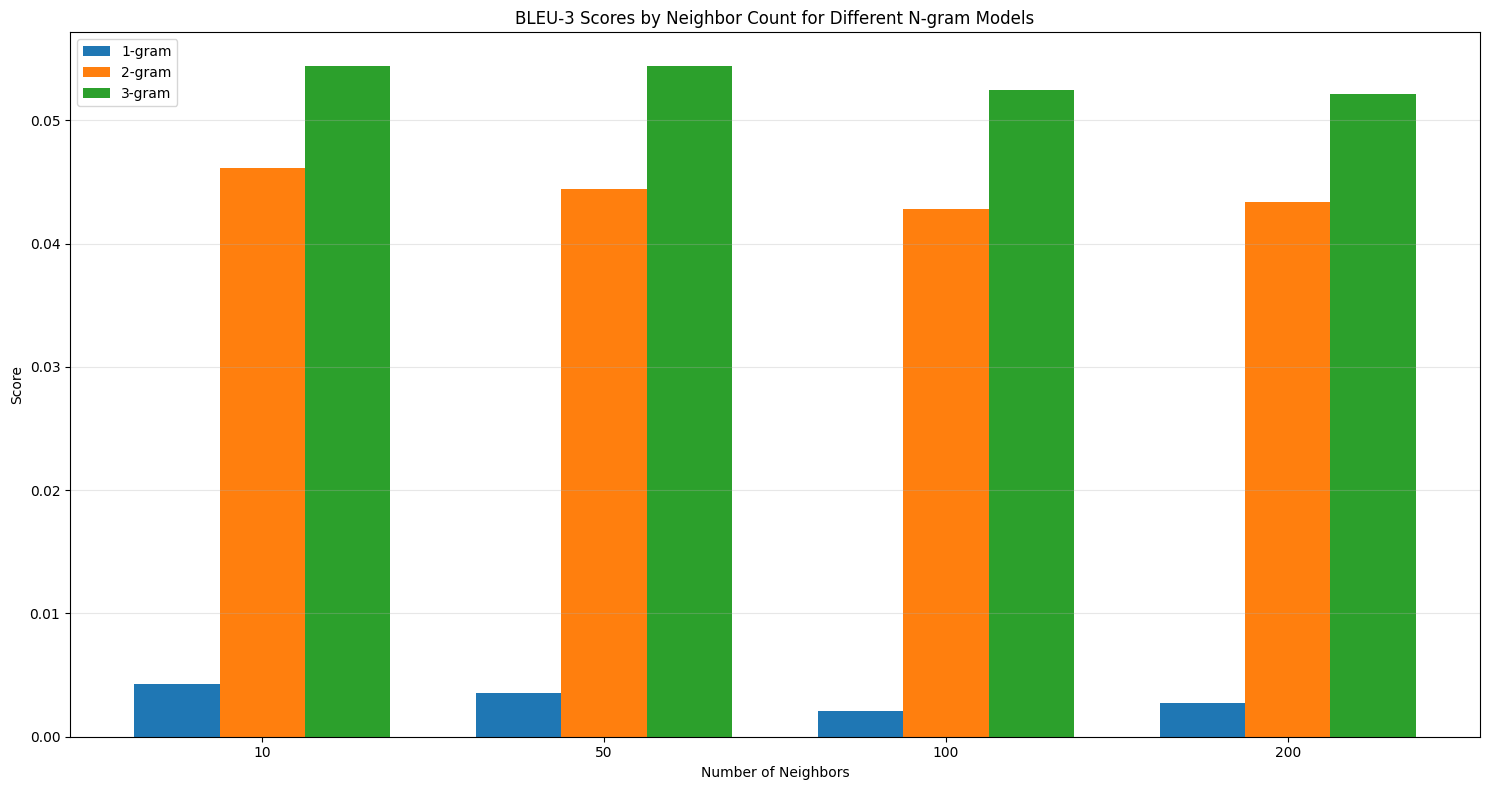

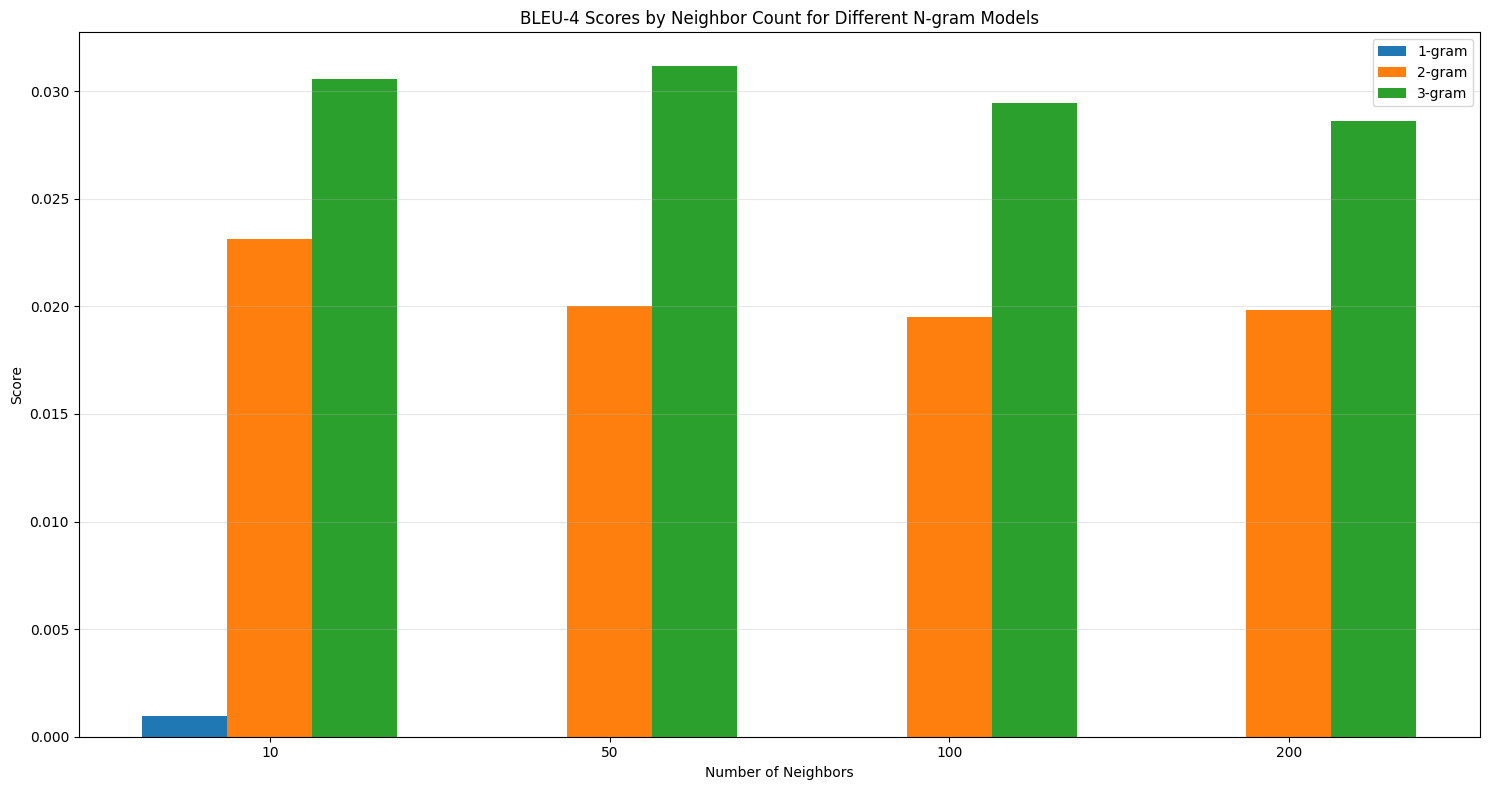

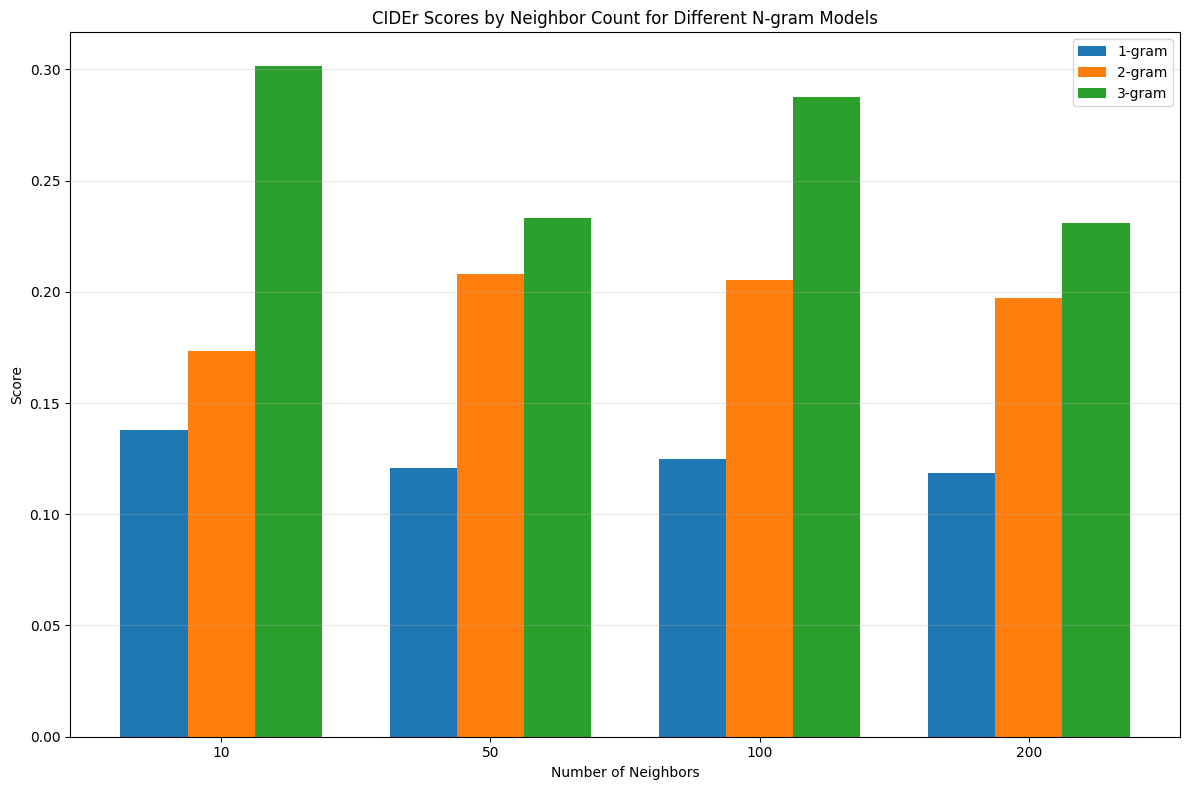

In [1]:
# NLG Evaluation for Chest X-Ray Report Generation Models
# This notebook evaluates model outputs using BLEU and CIDEr metrics
# Modified to evaluate different neighbor variations (10, 50, 100, 200)

import numpy as np
import pandas as pd
import subprocess
import os
import sys
from collections import defaultdict
import tqdm
from time import strftime, gmtime
import matplotlib.pyplot as plt
base_path = '/Users/simeon/Documents/DLH/content/mimic-cxr-project'
# Clone the interpretable-report-gen repository if it doesn't exist
repo_path = os.path.join(base_path, 'interpretable-report-gen')
if not os.path.exists(repo_path):
    print("Cloning interpretable-report-gen repository...")
    subprocess.run(['git', 'clone', 'https://github.com/stmharry/interpretable-report-gen.git', repo_path])
    print("Repository cloned successfully.")

# Add the repository path to the system path so we can import from it
if repo_path not in sys.path:
    sys.path.append(repo_path)

# Try to import the custom pycocoevalcap3 modules
try:
    sys.path.append(os.path.join(repo_path, 'pycocoevalcap3'))
    from pycocoevalcap3.bleu.bleu import Bleu
    from pycocoevalcap3.cider.cider import Cider
    print("Successfully imported custom pycocoevalcap3 metrics")
except ImportError as e:
    print(f"Error importing custom pycocoevalcap3: {e}")
    print("Falling back to standard pycocoevalcap")
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.cider.cider import Cider

# Define paths
base_path = '/Users/simeon/Documents/DLH/content/mimic-cxr-project'
data_dir = os.path.join(base_path, 'data')
output_dir = os.path.join(base_path, 'output')

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Helper function to ensure all values are strings
def ensure_string(item):
    if item is None:
        return ""
    return str(item)

# Function to evaluate a model using NLG metrics
def evaluate_model(model_name, references, predictions):
    """
    Evaluate a model using BLEU and CIDEr metrics

    Args:
        model_name (str): Name of the model being evaluated
        references (dict): Dictionary of reference texts
        predictions (dict): Dictionary of model predictions

    Returns:
        tuple: BLEU scores and CIDEr score
    """
    print(f"\nEvaluating {model_name} model...")

    # Find common IDs between reference and predictions
    common_ids = set(references.keys()) & set(predictions.keys())
    print(f"Number of cases with both reference and prediction: {len(common_ids)}")

    # Filter to keep only common IDs
    references_filtered = {k: references[k] for k in common_ids}
    predictions_filtered = {k: predictions[k] for k in common_ids}

    # Calculate BLEU scores
    bleu_scorer = Bleu(4)
    bleu_score = bleu_scorer.compute_score(references_filtered, predictions_filtered)
    print(f"{model_name} BLEU scores (n={len(predictions_filtered)}):")
    print(f"  BLEU-1: {bleu_score[0][0]:.4f}")
    print(f"  BLEU-2: {bleu_score[0][1]:.4f}")
    print(f"  BLEU-3: {bleu_score[0][2]:.4f}")
    print(f"  BLEU-4: {bleu_score[0][3]:.4f}")

    # Calculate CIDEr score
    cider_scorer = Cider(4)
    cider_score = cider_scorer.compute_score(references_filtered, predictions_filtered)
    # Scale CIDEr score by 10
    scaled_cider_score = cider_score[0] * 10
    print(f"{model_name} CIDEr score (scaled): {scaled_cider_score:.4f}")

    return bleu_score[0], scaled_cider_score

# Load reference/ground truth data
reference_path = os.path.join(output_dir, 'reference.tsv')
if not os.path.exists(reference_path):
    # If reference file doesn't exist, create it from test data
    print("Reference file not found. Extracting from test data...")

    # Import the report parser module to extract text from reports
    sys.path.append(f"{base_path}/modules")
    from report_parser import parse_report

    # Load test data
    test_df = pd.read_csv(os.path.join(data_dir, 'test.tsv'), sep='\t')

    # Extract findings from reports
    reports_dir = os.path.join(base_path, 'reports')

    # Create a dictionary to store the report text for each dicom_id
    reference_texts = {}

    for _, row in tqdm.tqdm(test_df.iterrows(), total=len(test_df)):
        dicom_id = row['dicom_id']
        study_id = row['study_id']
        subject_id = row['subject_id']

        # Construct path to the report
        subject_prefix = f"p{str(subject_id)[:2]}"
        subject_dir = f"p{subject_id}"
        study_dir = f"s{study_id}"
        report_path = os.path.join(reports_dir, 'files', subject_prefix, subject_dir, f"{study_dir}.txt")

        # Parse the report
        try:
            if os.path.exists(report_path):
                report = parse_report(report_path)

                # If the report has a findings section, add it
                if 'findings' in report:
                    reference_texts[dicom_id] = report['findings']
        except Exception as e:
            print(f"Error parsing report for {dicom_id}: {e}")

    # Save references to a TSV file
    reference_df = pd.DataFrame({
        'dicom_id': list(reference_texts.keys()),
        'text': list(reference_texts.values())
    })

    reference_df.to_csv(reference_path, sep='\t', index=False)
    print(f"Saved reference texts for {len(reference_texts)} test images to {reference_path}")
else:
    print(f"Loading reference texts from {reference_path}")
    reference_df = pd.read_csv(reference_path, sep='\t')
    print(f"Loaded reference texts for {len(reference_df)} test images")

# Create references dictionary in the format expected by the evaluation metrics
references = {k: [ensure_string(v)] for k, v in reference_df[['dicom_id', 'text']].values}

# Define the models to evaluate
# Add all variations of neighbor counts for n-gram models
base_models = ['random', '1-gram', '2-gram', '3-gram', '1nn']
ngram_models_with_neighbors = []

# Add neighbor variations for each n-gram model
for n in [1, 2, 3]:
    for k in [10, 50, 100, 200]:
        ngram_models_with_neighbors.append(f'{n}-gram_{k}nn')

# Combine base models and neighbor variations
models_to_evaluate = base_models + ngram_models_with_neighbors

# Authors' results from the paper (hardcoded) - Scale CIDEr by 10
paper_results = {
    'random': {
        'bleu': [0.265, 0.137, 0.070, 0.036],
        'cider': 0.570
    },
    '1-gram': {
        'bleu': [0.196, 0.000, 0.000, 0.000],
        'cider': 0.348
    },
    '2-gram': {
        'bleu': [0.194, 0.098, 0.043, 0.013],
        'cider': 0.404
    },
    '3-gram': {
        'bleu': [0.206, 0.107, 0.057, 0.031],
        'cider': 0.435
    },
    '1nn': {
        'bleu': [0.305, 0.171, 0.098, 0.057],
        'cider': 0.755
    }
}

# Dictionary to store our results
our_results = {}

# Evaluate each model
for model in models_to_evaluate:
    # Adjust file name based on model
    file_name = f"{model}.tsv"
    if model == '1nn':
        file_name = "1nn_reports.tsv"  # Adjust based on how you named your 1-NN output file

    model_path = os.path.join(output_dir, file_name)

    if os.path.exists(model_path):
        print(f"\nLoading {model} predictions from {model_path}")
        model_df = pd.read_csv(model_path, sep='\t')
        print(f"Loaded {len(model_df)} predictions")

        # Convert to format expected by evaluation metrics
        column_name = 'generated' if 'generated' in model_df.columns else 'prediction'
        predictions = {k: [ensure_string(v)] for k, v in model_df[['dicom_id', column_name]].values}

        # Evaluate the model
        bleu_scores, cider_score = evaluate_model(model, references, predictions)

        # Store results
        our_results[model] = {
            'bleu': bleu_scores,
            'cider': cider_score
        }
    else:
        print(f"\nWarning: {model} predictions file not found at {model_path}")
        print(f"Skipping evaluation for {model}")

# Create comparison visualizations for the base models
print("\nCreating comparison visualizations for base models...")

# Filter to include only base models that have results
base_models_with_results = [m for m in base_models if m in our_results]

# Create BLEU comparison plot for base models
plt.figure(figsize=(15, 10))

for i, metric in enumerate(['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']):
    plt.subplot(2, 2, i+1)

    # Data for plot
    models = base_models_with_results
    our_scores = [our_results[model]['bleu'][i] for model in models]
    paper_scores = [paper_results[model]['bleu'][i] for model in models]

    x = range(len(models))
    width = 0.35

    # Create bars
    plt.bar([i - width/2 for i in x], our_scores, width, label='Our Implementation')
    plt.bar([i + width/2 for i in x], paper_scores, width, label='Original Paper')

    # Add labels
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title(f'{metric} Comparison')
    plt.xticks(x, models)
    plt.grid(axis='y', alpha=0.3)

    # Add values on top of bars
    for j, v in enumerate(our_scores):
        plt.text(j - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    for j, v in enumerate(paper_scores):
        plt.text(j + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    if i == 0:  # Only add legend on the first subplot
        plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'bleu_comparison_base_models.png'))

# Create CIDEr comparison plot for base models
plt.figure(figsize=(10, 6))

# Data for plot
models = base_models_with_results
our_cider = [our_results[model]['cider'] for model in models]
paper_cider = [paper_results[model]['cider'] for model in models]

x = range(len(models))
width = 0.35

# Create bars
plt.bar([i - width/2 for i in x], our_cider, width, label='Our Implementation')
plt.bar([i + width/2 for i in x], paper_cider, width, label='Original Paper')

# Add labels
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('CIDEr Score Comparison')
plt.xticks(x, models)
plt.grid(axis='y', alpha=0.3)

# Add values on top of bars
for j, v in enumerate(our_cider):
    plt.text(j - width/2, v + 0.3, f'{v:.3f}', ha='center', va='bottom')

for j, v in enumerate(paper_cider):
    plt.text(j + width/2, v + 0.3, f'{v:.3f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cider_comparison_base_models.png'))

# Create a summary table for base models
print("\nSummary of results compared to the paper (base models):")
summary_data = []

for model in base_models:
    if model in our_results:
        row = {
            'Model': model,
            'BLEU-1 (Ours)': our_results[model]['bleu'][0],
            'BLEU-1 (Paper)': paper_results[model]['bleu'][0],
            'BLEU-2 (Ours)': our_results[model]['bleu'][1],
            'BLEU-2 (Paper)': paper_results[model]['bleu'][1],
            'BLEU-3 (Ours)': our_results[model]['bleu'][2],
            'BLEU-3 (Paper)': paper_results[model]['bleu'][2],
            'BLEU-4 (Ours)': our_results[model]['bleu'][3],
            'BLEU-4 (Paper)': paper_results[model]['bleu'][3],
            'CIDEr (Ours)': our_results[model]['cider'],
            'CIDEr (Paper)': paper_results[model]['cider']
        }
        summary_data.append(row)
    else:
        print(f"No results for {model}, skipping in summary table")

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Save summary table for base models
summary_df.to_csv(os.path.join(output_dir, 'evaluation_summary_base_models.csv'), index=False)
print(f"\nSaved summary table to {os.path.join(output_dir, 'evaluation_summary_base_models.csv')}")

# Create visualizations for n-gram models with different neighbor counts
# Filter to include only n-gram models with neighbor variations that have results
ngram_models_with_results = [m for m in ngram_models_with_neighbors if m in our_results]

# Group by n-gram value (1, 2, 3)
for n in [1, 2, 3]:
    # Filter models for this n-gram value
    current_models = [m for m in ngram_models_with_results if m.startswith(f'{n}-gram_')]

    if not current_models:
        print(f"No results for {n}-gram models with different neighbor counts")
        continue

    print(f"\nCreating visualizations for {n}-gram models with different neighbor counts...")

    # Create BLEU comparison plot
    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']):
        plt.subplot(2, 2, i+1)

        # Extract neighbor counts for x-axis labels
        neighbor_counts = [int(m.split('_')[1].replace('nn', '')) for m in current_models]

        # Sort models by neighbor count
        sorted_indices = np.argsort(neighbor_counts)
        sorted_models = [current_models[i] for i in sorted_indices]
        sorted_neighbor_counts = [neighbor_counts[i] for i in sorted_indices]

        # Get scores
        scores = [our_results[model]['bleu'][i] for model in sorted_models]

        # Create bars
        plt.bar(range(len(sorted_models)), scores)

        # Add labels
        plt.xlabel('Number of Neighbors')
        plt.ylabel('Score')
        plt.title(f'{n}-gram {metric} Scores by Neighbor Count')
        plt.xticks(range(len(sorted_models)), sorted_neighbor_counts)
        plt.grid(axis='y', alpha=0.3)

        # Add values on top of bars
        for j, v in enumerate(scores):
            plt.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{n}-gram_bleu_by_neighbors.png'))

    # Create CIDEr comparison plot
    plt.figure(figsize=(10, 6))

    # Get CIDEr scores
    cider_scores = [our_results[model]['cider'] for model in sorted_models]

    # Create bars
    plt.bar(range(len(sorted_models)), cider_scores)

    # Add labels
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'{n}-gram CIDEr Scores by Neighbor Count')
    plt.xticks(range(len(sorted_models)), sorted_neighbor_counts)
    plt.grid(axis='y', alpha=0.3)

    # Add values on top of bars
    for j, v in enumerate(cider_scores):
        plt.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{n}-gram_cider_by_neighbors.png'))

# Create comparison plots across all n-gram models with different neighbor counts
# Create dictionary to store results by neighbor count
results_by_neighbors = {}

# Extract and organize results by neighbor count
for model in ngram_models_with_results:
    parts = model.split('_')
    n_gram = parts[0]
    neighbor_count = int(parts[1].replace('nn', ''))

    if neighbor_count not in results_by_neighbors:
        results_by_neighbors[neighbor_count] = {}

    results_by_neighbors[neighbor_count][n_gram] = our_results[model]

# Sort neighbor counts
neighbor_counts = sorted(results_by_neighbors.keys())

# Create BLEU comparison plots by neighbor count
for metric_idx, metric_name in enumerate(['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']):
    plt.figure(figsize=(15, 8))

    # Prepare data for plotting
    n_gram_values = ['1-gram', '2-gram', '3-gram']
    x = range(len(neighbor_counts))
    width = 0.25

    # Plot each n-gram model series
    for i, n_gram in enumerate(n_gram_values):
        scores = []

        for k in neighbor_counts:
            if n_gram in results_by_neighbors[k]:
                scores.append(results_by_neighbors[k][n_gram]['bleu'][metric_idx])
            else:
                scores.append(0)  # Use 0 for missing values

        plt.bar([xi + (i-1)*width for xi in x], scores, width, label=n_gram)

    # Add labels
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'{metric_name} Scores by Neighbor Count for Different N-gram Models')
    plt.xticks(x, neighbor_counts)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{metric_name}_comparison_by_neighbors.png'))

# Create CIDEr comparison plot by neighbor count
plt.figure(figsize=(12, 8))

# Prepare data for plotting
n_gram_values = ['1-gram', '2-gram', '3-gram']
x = range(len(neighbor_counts))
width = 0.25

# Plot each n-gram model series
for i, n_gram in enumerate(n_gram_values):
    scores = []

    for k in neighbor_counts:
        if n_gram in results_by_neighbors[k]:
            scores.append(results_by_neighbors[k][n_gram]['cider'])
        else:
            scores.append(0)  # Use 0 for missing values

    plt.bar([xi + (i-1)*width for xi in x], scores, width, label=n_gram)

# Add labels
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.title('CIDEr Scores by Neighbor Count for Different N-gram Models')
plt.xticks(x, neighbor_counts)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cider_comparison_by_neighbors.png'))

# Create a comprehensive summary table for all n-gram models with neighbor variations
print("\nSummary of results for n-gram models with different neighbor counts:")
neighbor_summary_data = []

for model in ngram_models_with_results:
    if model in our_results:
        n_gram = model.split('_')[0]
        neighbor_count = model.split('_')[1].replace('nn', '')

        row = {
            'Model': n_gram,
            'Neighbors': neighbor_count,
            'BLEU-1': our_results[model]['bleu'][0],
            'BLEU-2': our_results[model]['bleu'][1],
            'BLEU-3': our_results[model]['bleu'][2],
            'BLEU-4': our_results[model]['bleu'][3],
            'CIDEr': our_results[model]['cider']
        }
        neighbor_summary_data.append(row)

if neighbor_summary_data:
    neighbor_summary_df = pd.DataFrame(neighbor_summary_data)
    print(neighbor_summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # Save neighbor summary table
    neighbor_summary_df.to_csv(os.path.join(output_dir, 'evaluation_summary_by_neighbors.csv'), index=False)
    print(f"\nSaved neighbor summary table to {os.path.join(output_dir, 'evaluation_summary_by_neighbors.csv')}")
else:
    print("No results found for n-gram models with different neighbor counts")

print("All visualizations have been generated and saved to the output directory.")